In [32]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

In [33]:
def OneHotEncode(target_labels):
    '''
    OneHotEncode function is a function generated to encode label matrices into One hot encoding vectors.
    The idea is turn the matrix into a (M, c) matrix where M is the number of samples and c is the amount of possible labels.
    '''
    # turn the vector into a list:
    labels = target_labels.tolist()
    # get the number of classes
    classification_set = set(labels)
    n_C = len(classification_set)

    # Loop over the clasification clases in order to generate the expected one hot encodings for each one.
    for index, value in enumerate(classification_set):
        zero = np.zeros((1, n_C))
        if index == 0:
            zero[:,index] = 1
            one_hot_classes[value]= zero 
        else:
            zero[:,index] = 1
            one_hot_classes[value]= zero

    #Loop over the values in order to turn each label into a one hot encoded vector
    for i, example in enumerate(labels):
        labels[i] = one_hot_classes[example]
    labels = np.vstack(labels)
    return labels

In [34]:
#Train-Test split: generates training and test set with a 80% and 20% respectively from the dataset:
def cross_validation_set(X, Y): 
    #get the number of samples
    M= X.shape[0]
    #shuffle the matrix in order to get a random order of samples
    permutation = np.random.permutation(M)
    X_shuffled = X[permutation]
    Y_shuffled = Y[permutation]
    
    #extract 80% for training set and 20% for test set. 
    train_limit = int(M*0.8)
    X_train = X_shuffled[:train_limit]
    Y_train = Y_shuffled[:train_limit]
    X_test = X_shuffled[train_limit:]
    Y_testing = Y_shuffled[train_limit:]
    return X_train, Y_train, X_test, Y_testing

#  Dataset Iris

The Iris dataset is a popular multivariate dataset that was introduced by the British statistician and biologist Ronald Fisher in 1936. It contains measurements of 150 samples of iris flowers from three different species: Iris setosa, Iris versicolor, and Iris virginica. Each sample contains measurements of four different features: sepal length, sepal width, petal length, and petal width, all measured in centimeters

The dataset is often used in machine learning and pattern recognition research as a benchmark dataset due to its simplicity and accessibility. Thats why in order to show the working neural network we are going to use this dataset, and show the results on its predictions.

In [35]:
iris = datasets.load_iris()
data = iris.data
labels = iris.target

In [36]:
labels = OneHotEncode(labels)

In [37]:
print("X shape: ", data.shape, "\nY shape", labels.shape)

X shape:  (150, 4) 
Y shape (150, 3)


# Data Normalization: 
It is known that one way to achieve faster training is by using normalization of input data. This is because normalized data allows for a more uniform optimization region, which in turn allows the gradient descent method to be faster, as the gradients allow for a more direct movement towards the minima. The next two code blocks use two well-known normalization methods.

# Method 1 Z-score: 
Normalization of data using the mean $\mu$ and the standrd deviation $\sigma$:
This is the typical formula for data normalization in statistics that allows data to be transformed from its distribution to a standard normal distribution (0, 1). Since the data has its own distribution in each coordinate, the mean and standard deviation are calculated among all examples for each coordinate, and then subtracted from the data. The formula is used for each coordinate as follows:

$$Z_{i} = \frac{x_{i}-\mu}{\sigma^{2}}$$

This allows the data to cluster around $[-1, 1]$ with a probability of 0.66. The main difference with the other method is that it does not guarantee that the value will be between 0 and 1, but rather that most of them will be.

In [38]:
def mean_normalization(data):
    mu_data = np.mean(data, axis= 0, keepdims = True)
    std_data = np.std(data, axis = 0, keepdims = True)
    print('shape de la media ' + str(mu_data.shape))
    print('shape de la desviación estandard '+str(std_data.shape))
    #data Normalization: 
    return (data-mu_data)/np.square(std_data)

# Método Número 2: 
This normalization method uses the maximum and minimum values on each coordinate to reescale the inputs. The values of the dataset get restricted to the $[0, 1]$ interval. This type of method is sensible to outliers because the minimum and maximum operations do not consider the rest of the values (as the mean would do). So if the maximum or minimum values are outliers in the data, the scaling method will not help learning. 

$$Z_{i} = \frac{x_{i}-min}{max - min}$$

In [39]:
def max_min_normalization(data):
    data_max = np.max(data, axis=0)
    data_min = np.min(data, axis=0)
    return (data-data_min)/(data_max-data_min)

In [40]:
## Activation function generation 
#tanh function
def tanh(X):
    exp = np.exp(X)
    exp_ = np.exp(-1*X)
    tanh = (exp-exp_)/(exp+exp_)
    return tanh

#softmax function: 
def softmax(X):
    exp = np.exp(X, dtype= np.float64)
    sum_exp = np.sum(exp, axis=1)
    sum_exp = np.expand_dims(sum_exp, -1)
    # constant term is summed to avoid infinity.
    return exp/(sum_exp+0.002)

#ReLU:
def relu(x):
    return np.where(x>0, x, 0)

# Derivative Functions:
# Tanh Derivative:
def dtanh(x):
    return 1 - np.square(tanh(x))

#ReLU derivative:
def drelu(x):
    return np.where(x>=0, 1, 0)


# MLP Class: 
class MLP:
    def __init__(self, X, Y, n_layers, n_hidden_units, named_labels, activation='tanh'):
        # Neural Network, dictionary in order to save derivatives, forward:
        #pesos:
        W = dict()
        #bias
        b = dict()
        #Z = WX+b derivative
        dZ = dict()
        # weight derivative
        dW = dict()
        # bias derivative
        db = dict()
        # forward  values A = f(Z)
        A_cache = dict()
        # forward Z values.
        Z_cache = dict()
        
        # activation functions are stored
        self.__activation__ = activation
        # generated labels (Confusion Matrix)
        self.named_labels = named_labels
        # Amount of layers
        self.n_layers = n_layers
        # defined Learning rate
        self.learning_rate = 0.1
        
        # Generate Weight values:
        first_shape = X.shape[1]
        # Amount of hiddent units:
        second_shape = n_hidden_units
        for layer in range(n_layers):
            # user can choose between tanh and ReLU:
            if activation == 'tanh':
                W['W'+str(layer+1)] = (1/np.sqrt(second_shape))*np.random.rand(first_shape, second_shape)
            elif activation == 'relu':
                W['W'+str(layer+1)] = (1/np.sqrt(second_shape))*np.random.rand(first_shape, second_shape)
            else:
                raise Exception('Only tanh or relu activation functions work. Use those instead')
            b['b'+str(layer+1)] = np.zeros((1,second_shape))
            first_shape = second_shape
        W['W'+str(self.n_layers+1)] = (2/np.sqrt(second_shape))*np.random.rand(n_hidden_units, Y.shape[1])
        b['b'+str(self.n_layers+1)] = np.zeros((1, Y.shape[1]))
        # parameter Dictionary
        self.parameters = dict()
        self.parameters['W'] = W
        self.parameters['b'] = b
        self.parameters['dZ'] = dZ
        self.parameters['dW'] = dW
        self.parameters['db'] = db
        self.parameters['A_cache'] = A_cache
        self.parameters['Z_cache'] = Z_cache
    
    def forwardPass(self, X, parameters):
        W = parameters['W']
        b = parameters['b']
        A_cache = dict()
        Z_cache = dict()
        In = X 
        # the input is saved in A dictionary, we will use it later for BP
        A_cache['A0']= X
        #we loop through layers:
        for layer in range(self.n_layers):
            # generate  Z: Wx+b
            Z = np.dot(In, W['W'+str(layer+1)])+b['b'+str(layer+1)]
            # save Z in the dictionary, we will use it later for BP:
            Z_cache['Z'+str(layer+1)] = Z 
            if self.__activation__ == 'tanh':
                A = tanh(Z)
            else:
                A = relu(Z)
            # We save A in the dictionary for BP calculation
            A_cache['A'+str(layer+1)] = A
            In = A
        # Calculate the output layer
        Z = np.dot(In, W['W'+str(self.n_layers+1)])+b['b'+str(self.n_layers+1)]
        Z_cache['Z'+str(self.n_layers+1)] = Z 
        # Calculate the prediction of the model
        Y_pred = softmax(Z) 
        
        
        # generate another dictionary to avoid mutation
        model_parameters = dict()
        model_parameters['W'] = W
        model_parameters['b'] = b
        model_parameters['dW'] = parameters['dW']
        model_parameters['db'] = parameters['db']
        model_parameters['dZ'] = parameters['dZ']
        model_parameters['A_cache'] = A_cache
        model_parameters['Z_cache'] = Z_cache
        
        return Y_pred, model_parameters 
    
    # Cross entropy loss:
    def Loss(self, Y_pred, Y_real):
        log_Ypred = np.log(Y_pred+0.000002)
        Ylog_Ypred = -Y_real*log_Ypred
        L_i = np.sum(Ylog_Ypred, axis= 1)
        loss = np.mean(L_i)
        return loss
        
    #Function that given a prediction of the model and a label, calculates the gradients of weights:    
    def backPropagation(self, Y_pred, Y, parameters):
        W = parameters['W']  
        A_cache = parameters['A_cache']
        Z_cache = parameters['Z_cache']
        dZ = parameters['dZ']
        dW = parameters['dW'] 
        db = parameters['db']
        # Save the amount of examples:
        M = Y.shape[0]
        # Dz has a shape (M, C) where M is the number of examples and  C is the number of classes:
        dZ['Z'+str(self.n_layers+1)] = (Y_pred - Y)
        # DW for the last layer has the shape (n_[l-1], C) where n_[l-1] is the amount of hidden units of layer l-1 
        # and C the number of classes: 
        # multiply A.T (A Transpose) by dZ to obtain a matrix of shape (n_[l-1], M)X(M, C)= (n_[l-1], C).
        dW['W'+str(self.n_layers+1)] = np.dot(A_cache['A'+str(self.n_layers)].T, dZ['Z'+str(self.n_layers+1)])
        db['b'+str(self.n_layers+1)] = (1/M)*np.sum(dZ['Z'+str(self.n_layers+1)], axis=0, keepdims=True)
        # calculate BP for every layer in reverse (we already calculated the derivatives for the last layer):
        for layer in range(self.n_layers, 0, -1):
            # dZ[l] has shape (M, n_[l]) and W[l] has shape (n_[l-1], n_l[l]) dZ[l]xW.T has the correct dimensions as
            # as dZ[l-1] has shape (M, n[l-1])
            if self.__activation__ == 'tanh':
                dZ['Z'+str(layer)] = np.dot(dZ['Z'+str(layer+1)], W['W'+str(layer+1)].T)*dtanh(Z_cache['Z'+str(layer)])
            else:
                dZ['Z'+str(layer)] = np.dot(dZ['Z'+str(layer+1)], W['W'+str(layer+1)].T)*drelu(Z_cache['Z'+str(layer)])
            # DW for the  l-th has shape (n_[l-1], n_[l]) we multiply A.T por dZ 
            # so we get a shape of (n_[l-1], M)X(M, n_[l])= (n_[l-1], C): 
            dW['W'+str(layer)] = (1/M)*np.dot(A_cache['A'+str(layer-1)].T, dZ['Z'+str(layer)])
            db['b'+str(layer)] = (1/M)*np.sum(dZ['Z' + str(layer)], axis=0, keepdims=True)
        #save parameters:    
        parameters['dZ'] = dZ
        parameters['dW'] = dW
        parameters['db'] = db
        # updates weights
        parameters = self.update_parameters(parameters)
        return parameters
        
    
    # Function that updates weights of the network
    def update_parameters(self, parameters):
        W = parameters['W']
        b = parameters['b']
        dW = parameters['dW'] 
        db = parameters['db']
        for layer in range(1, self.n_layers+1, 1):
            #apply gradient descent:
            W['W'+str(layer+1)] = W['W'+str(layer+1)]-self.learning_rate*dW['W'+str(layer+1)]
            b['b'+str(layer+1)] = b['b'+str(layer+1)]-self.learning_rate*db['b'+str(layer+1)]
        parameters['W'] = W
        parameters['b'] = b
        self.parameters
        return parameters
        
    
    # Function that calculates accuracy: 
    def calc_accuracy(self, Y_pred, Y):
        pred = np.expand_dims(np.argmax(Y_pred, axis=-1), -1)
        real = np.expand_dims(np.argmax(Y, axis=-1),-1)
        acc = np.sum((pred==real))/Y.shape[0]
        return acc
    
    # predict function: predicts the output of the network, does not calculate gradient:
    def predict(self, X, parameters):
        W = parameters['W']
        b = parameters['b']
        In = X 
        for layer in range(self.n_layers):
            Z = np.dot(In, W['W'+str(layer+1)])+b['b'+str(layer+1)]
            if self.__activation__ == 'tanh':
                A = tanh(Z)
            elif self.__activation__ == 'relu':
                A = relu(Z)
            In = A
        Z = np.dot(In, W['W'+str(self.n_layers+1)])+b['b'+str(self.n_layers+1)]
        Y_pred = softmax(Z) 
        return Y_pred

    # function that computes the confusion matrix:        
    def confusion_matrix(self, Y_pred, Y):
        real_labels = np.expand_dims(np.argmax(Y, axis=-1),-1)
        pred_labels = np.expand_dims(np.argmax(Y_pred, axis=-1), -1)
        N_labels = len(self.named_labels)
        conf_M = np.zeros((N_labels, N_labels))
        for example in range(real_labels.shape[0]):
            row = real_labels[example]
            column = pred_labels[example]
            conf_M[row, column] += 1
        conf_M = pd.DataFrame(conf_M, self.named_labels, self.named_labels)
        return conf_M
        
    #Training function (trains the MLP for a given amount of epochs ):
    def train(self, X, Y, Epochs, learning_rate):
        # get the parameters
        parameters = self.parameters
        # generate list for losses and acurracies:
        training_loss = list()
        training_accuracy = list()
        
        # set learning rate
        self.learning_rate= learning_rate
        #se separa la data
        X_train, Y_train, X_test, Y_test = cross_validation_set(X, Y)
        
        # loop for a given number of epochs:
        for epoch in range(1, Epochs+1):
            # generate predictions and calculate caches (Z_cache, A_cache)
            Y_pred, parameters = self.forwardPass(X_train, parameters)
            
            # calculate loss:
            train_loss = self.Loss(Y_pred, Y_train)
            
            # calculate accuracy:
            train_acc = self.calc_accuracy(Y_pred, Y_train)
            
            # add the values to the accuracy and loss lists:
            training_loss.append(train_loss)
            training_accuracy.append(train_acc)
            
            # every 100 epochs the values of accuracy and loss:
            if epoch%100==0:
                print('Epoch {N_epoch} is train loss: {loss}, train accuracy: {accuracy}'.format(N_epoch=epoch, loss=train_loss,\
                                                                                                            accuracy= train_acc))
            # update weights  
            parameters = self.backPropagation(Y_pred, Y_train, parameters)
            
        
        # predict the values:
        Y_pred_test = self.predict(X_test, parameters)
        # calculate loss:
        testing_loss = self.Loss(Y_pred_test, Y_test)
        
        # calculate accuracy:
        testing_accuracy = self.calc_accuracy(Y_pred_test, Y_test) 
        
        # print the results of training
        print('Trainig is done:')
        print('the training loss is {loss} and the training accuracy is {acc}'.format(loss = np.mean(training_loss), acc=train_acc))
        print('the testing loss is {loss} and the testing accuracy is {acc}'.format(loss = testing_loss, acc= testing_accuracy))
        
        # plot losses and accuracy per epoch
        fig, ax = plt.subplots()
        train = ax.plot(range(1, Epochs+1), training_loss, '-b', label='training loss')
        ax.set_title('models loss with {epochs} epochs of training'.format(epochs=Epochs))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('loss')
        ax.set_ylim([0,5])
        plt.show()

        fig, ax = plt.subplots()
        train = ax.plot(range(1, Epochs+1), training_accuracy, '-b', label='training accuracy')
        ax.set_title('models accuracy with {epochs} epochs of training'.format(epochs=Epochs))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('accuracy')
        ax.set_ylim([0,1])
        plt.show()
        plt.show()
        print('plot of the confusion matrix, where the rows represent the real data and the columns the predicted data:')
        
        # print confusion matrix
        cM = self.confusion_matrix(Y_test, Y_pred_test)
        print(cM)
            

# First MLP to train: 4 layers, 10 hidden units

In [41]:
named_classes = list(classification_set)
myMlp = MLP(data, labels, n_layers = 4, n_hidden_units=10, named_labels=named_classes)

In [42]:
X = mean_normalization(data)
Y = labels

shape de la media (1, 4)
shape de la desviación estandard (1, 4)


Epoch 100 is train loss: 0.8256407914952355, train accuracy: 0.575
Epoch 200 is train loss: 0.6336429806919064, train accuracy: 0.7083333333333334
Epoch 300 is train loss: 0.27047314920544047, train accuracy: 0.8833333333333333
Epoch 400 is train loss: 0.217552654470145, train accuracy: 0.9083333333333333
Epoch 500 is train loss: 0.18921952001104697, train accuracy: 0.9333333333333333
Epoch 600 is train loss: 0.1589753754585372, train accuracy: 0.9333333333333333
Epoch 700 is train loss: 0.12581730660390347, train accuracy: 0.9416666666666667
Epoch 800 is train loss: 0.09173631355483572, train accuracy: 0.9666666666666667
Epoch 900 is train loss: 0.06397723879773047, train accuracy: 0.975
Trainig is done:
the training loss is 0.3495411039375506 and the training accuracy is 0.975
the testing loss is 0.16852913962890587 and the testing accuracy is 0.9333333333333333


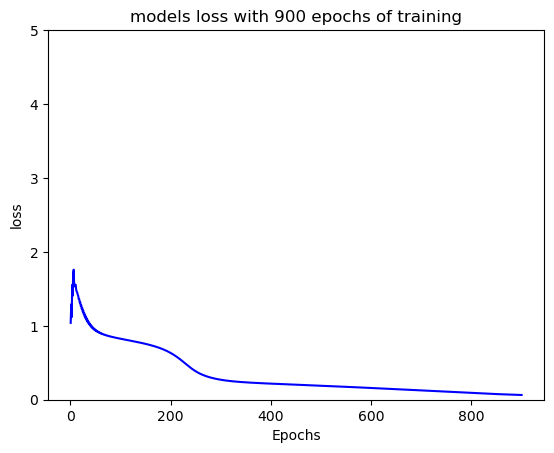

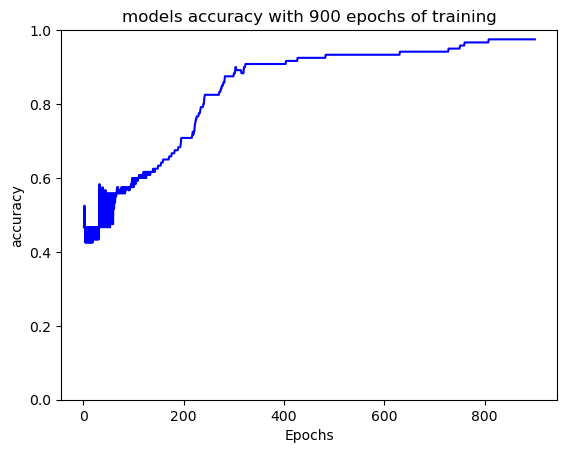

plot of the confusion matrix, where the rows represent the real data and the columns the predicted data:
                   Iris-versicolor\n  Iris-setosa\n  Iris-virginica\n
Iris-versicolor\n               11.0            0.0               0.0
Iris-setosa\n                    0.0            4.0               0.0
Iris-virginica\n                 0.0            2.0              13.0


In [43]:
myMlp.train(X, Y, 900, 0.02)

# Second MLP Structure: 5 layers , 7 hidden units:
The network is trained over 700 epochs

Epoch 100 is train loss: 0.9056886770670808, train accuracy: 0.5666666666666667
Epoch 200 is train loss: 0.6908632691083307, train accuracy: 0.6833333333333333
Epoch 300 is train loss: 0.4996584893360055, train accuracy: 0.7666666666666667
Epoch 400 is train loss: 0.5056398042138862, train accuracy: 0.75
Epoch 500 is train loss: 0.4826180019435005, train accuracy: 0.7583333333333333
Epoch 600 is train loss: 0.46055643871823065, train accuracy: 0.7666666666666667
Epoch 700 is train loss: 0.44851777308281987, train accuracy: 0.7916666666666666
Trainig is done:
the training loss is 0.6245455297211667 and the training accuracy is 0.7916666666666666
the testing loss is 0.2742078054157633 and the testing accuracy is 0.8


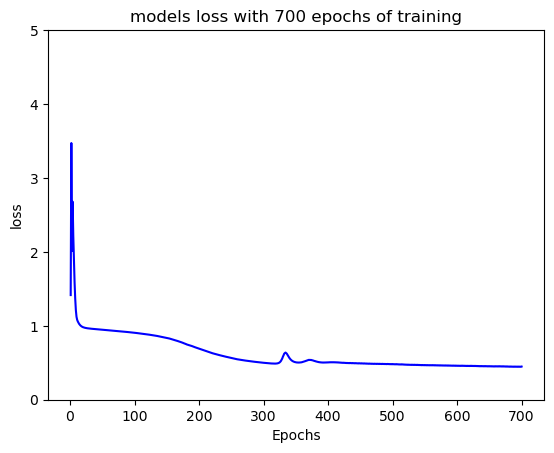

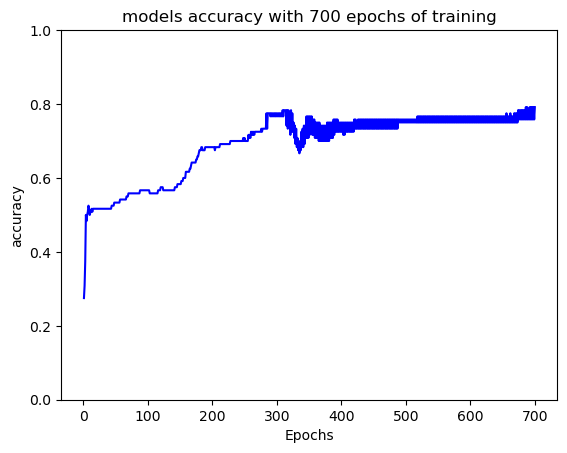

plot of the confusion matrix, where the rows represent the real data and the columns the predicted data:
                   Iris-versicolor\n  Iris-setosa\n  Iris-virginica\n
Iris-versicolor\n                5.0            6.0               0.0
Iris-setosa\n                    0.0            6.0               0.0
Iris-virginica\n                 0.0            0.0              13.0


In [44]:
myMlp2 = MLP(data, labels, n_layers = 3, n_hidden_units=15, named_labels=named_classes, activation='relu')
myMlp2.train(X, Y, 700, 0.04)